In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"
#changing the working directory
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [ ]:
import numpy as np
import pandas as pd
import wave
from scipy.io import wavfile
import os
import librosa
from librosa.feature import melspectrogram
import warnings
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from PIL import Image
from uuid import uuid4
import sklearn
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, LSTM, SimpleRNN, Conv1D, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/kaggle/bird_det/train.csv')

In [ ]:
train_df = train_df.query("rating>=4")

birds_count = {}
for bird_species, count in zip(train_df.ebird_code.unique(), train_df.groupby("ebird_code")["ebird_code"].count().values):
    birds_count[bird_species] = count
most_represented_birds = [key for key,value in birds_count.items() if value == 100]

train_df = train_df.query("ebird_code in @most_represented_birds")

In [ ]:
len(train_df.ebird_code.unique())

49

In [ ]:
birds_to_recognise = sorted(shuffle(most_represented_birds)[:20])
print(birds_to_recognise)

['amerob', 'astfly', 'blujay', 'buggna', 'comter', 'comyel', 'gnwtea', 'greegr', 'herthr', 'linspa', 'mallar3', 'marwre', 'norfli', 'normoc', 'redcro', 'swathr', 'warvir', 'wesmea', 'whbnut', 'whtspa']


In [ ]:
train_df = shuffle(train_df)
train_df.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,number_of_notes,title,secondary_labels,bird_seen,sci_name,location,latitude,sampling_rate,type,elevation,description,bitrate_of_mp3,file_type,volume,background,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
1459,5.0,no,barswa,1 (mono),2015-02-01,Not specified,21,XC288339.mp3,Not specified,Barn Swallow,Not specified,XC288339 Barn Swallow (Hirundo rustica),[],yes,Hirundo rustica,"Castelândia, Porteirão, Goiás",-18.0737,48000 (Hz),"call, song",420 m,NaN,128000 (bps),mp3,Not specified,NaN,288339,https://www.xeno-canto.org/288339,Brazil,Marcelo Villegas,Hirundo rustica_Barn Swallow,-50.1745,Not specified,08:30,Marcelo Villegas,Creative Commons Attribution-NonCommercial-Sha...
12869,5.0,no,marwre,2 (stereo),2019-05-24,Not specified,48,XC479944.mp3,Not specified,Marsh Wren,Not specified,XC479944 Marsh Wren (Cistothorus palustris),[],yes,Cistothorus palustris,"Greater Vancouver A (near Richmond), Greater...",49.2204,48000 (Hz),song,10 m,Recording normalized to -3dB.,320000 (bps),mp3,Not specified,NaN,479944,https://www.xeno-canto.org/479944,Canada,Sunny Tseng,Cistothorus palustris_Marsh Wren,-123.2089,Not specified,08:00,Sunny Tseng,Creative Commons Attribution-NonCommercial-Sha...
5665,5.0,no,chispa,2 (stereo),2018-06-01,level,89,XC418151.mp3,level,Chipping Sparrow,>20,XC418151 Chipping Sparrow (Spizella passerina),[],no,Spizella passerina,"Fraser-Fort George C, Fraser-Fort George, Bri...",53.4842,44100 (Hz),song,750 m,Bird singing from a replanted cut-block,128000 (bps),mp3,level,NaN,418151,https://www.xeno-canto.org/418151,Canada,Jeff Dyck,Spizella passerina_Chipping Sparrow,-123.1101,3-6(s),20:30,Jeff Dyck,Creative Commons Attribution-NonCommercial-Sha...
16238,5.0,NaN,rewbla,2 (stereo),2013-06-12,Not specified,124,XC164112.mp3,Not specified,Red-winged Blackbird,Not specified,XC164112 Red-winged Blackbird (Agelaius phoeni...,[],NaN,Agelaius phoeniceus,"Foam Lake No. 276 (near Leslie), Division No...",51.7772,44100 (Hz),song,550 m,Modifications: None\n\nbird-seen:no,128000 (bps),mp3,Not specified,NaN,164112,https://www.xeno-canto.org/164112,Canada,Patrick Turgeon,Agelaius phoeniceus_Red-winged Blackbird,-103.5795,Not specified,07:02,Patrick Turgeon,Creative Commons Attribution-NonCommercial-Sha...
19399,5.0,no,wesmea,1 (mono),2012-03-04,Not specified,81,XC161774.mp3,Not specified,Western Meadowlark,Not specified,XC161774 Western Meadowlark (Sturnella neglecta),[],yes,Sturnella neglecta,"Tijuana Slough NWR, trail from south end of 5...",32.564,48000 (Hz),"call, song",0 m,NaN,128000 (bps),mp3,Not specified,NaN,161774,https://www.xeno-canto.org/161774,United States,Paul Marvin,Sturnella neglecta_Western Meadowlark,-117.1256,Not specified,10:47,Paul Marvin,Creative Commons Attribution-NonCommercial-Sha...


In [ ]:
len(train_df)

4900

In [ ]:
def get_sample(filename, bird, output_folder):
    wave_data, wave_rate = librosa.load(filename)
    wave_data, _ = librosa.effects.trim(wave_data)
    #only take 5s samples and add them to the dataframe
    song_sample = []
    sample_length = 5*wave_rate
    samples_from_file = []
    #The variable below is chosen mainly to create a 216x216 image
    N_mels=216
    for idx in range(0,len(wave_data),sample_length):
        song_sample = wave_data[idx:idx+sample_length]
        if len(song_sample)>=sample_length:
            mel = melspectrogram(song_sample, n_mels=N_mels)
            db = librosa.power_to_db(mel)
            normalised_db = sklearn.preprocessing.minmax_scale(db)
            filename = str(uuid4())+".tif"
            db_array = (np.asarray(normalised_db)*255).astype(np.uint8)
            db_image =  Image.fromarray(np.array([db_array, db_array, db_array]).T)
            db_image.save("{}{}".format(output_folder,filename))

            samples_from_file.append({"song_sample":"{}{}".format(output_folder,filename),
                                            "bird":bird})
    return samples_from_file

In [ ]:
%%time
warnings.filterwarnings("ignore")
samples_df = pd.DataFrame(columns=["song_sample","bird"])

#We limit the number of audio files being sampled to 1000 in this notebook to save time
#on top of having limited the number of bird species previously
sample_limit = 1000
sample_list = []

output_folder = "/content/drive/MyDrive/kaggle/"
os.makedirs(output_folder, exist_ok=True)
#os.mkdir(output_folder)
with tqdm(total=sample_limit) as pbar:
    for idx, row in train_df[:sample_limit].iterrows():
        pbar.update(1)
        try:
            audio_file_path = "/content/drive/MyDrive/kaggle/bird_det/train_audio/"
            audio_file_path += row.ebird_code

            if row.ebird_code in birds_to_recognise:
                sample_list += get_sample('{}/{}'.format(audio_file_path, row.filename), row.ebird_code, output_folder)
            else:
                sample_list += get_sample('{}/{}'.format(audio_file_path, row.filename), "nocall", output_folder)
        except:
            raise
            print("{} is corrupted".format(audio_file_path))

samples_df = pd.DataFrame(sample_list)

100%|██████████| 1000/1000 [1:05:55<00:00,  3.96s/it]


CPU times: user 46min 49s, sys: 7min 52s, total: 54min 42s
Wall time: 1h 5min 56s


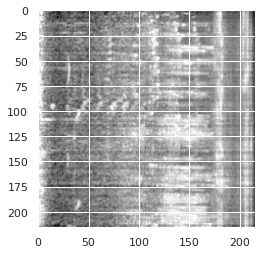

In [ ]:
demo_img = Image.open(samples_df.iloc[0].song_sample)
plt.imshow(demo_img)
plt.show()

In [ ]:
samples_df = shuffle(samples_df)
samples_df[:10]

,song_sample,bird
1301,/content/drive/MyDrive/kaggle/ea043801-7a08-45...,nocall
2137,/content/drive/MyDrive/kaggle/b6808d02-64f3-40...,marwre
1402,/content/drive/MyDrive/kaggle/6b35fe71-a936-48...,herthr
2834,/content/drive/MyDrive/kaggle/a4c0abd0-f609-49...,warvir
7691,/content/drive/MyDrive/kaggle/6a72ac0a-f7cf-44...,nocall
3671,/content/drive/MyDrive/kaggle/f73d1552-bdcc-40...,nocall
3581,/content/drive/MyDrive/kaggle/517881a5-7d01-4f...,astfly
1155,/content/drive/MyDrive/kaggle/265f2e32-c24c-4d...,nocall
4861,/content/drive/MyDrive/kaggle/724e25da-3056-46...,nocall
11593,/content/drive/MyDrive/kaggle/7b842451-8705-48...,nocall


# Model creation

In [ ]:
training_percentage = 0.9
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:]

In [ ]:
classes_to_predict = sorted(samples_df.bird.unique())
input_shape = (216,216, 3)
effnet_layers = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)

for layer in effnet_layers.layers:
    layer.trainable = True

dropout_dense_layer = 0.3

model = Sequential()
model.add(effnet_layers)

model.add(GlobalAveragePooling2D())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(len(classes_to_predict), activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327680    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                5

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.7),
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss="categorical_crossentropy", optimizer='adam')

In [ ]:
class_weights = class_weight.compute_class_weight("balanced", classes_to_predict, samples_df.bird.values)
class_weights_dict = {i : class_weights[i] for i,label in enumerate(classes_to_predict)}

In [ ]:
training_batch_size = 32
validation_batch_size = 32
target_size = (216,216)

train_datagen = ImageDataGenerator(
    rescale=1. / 255
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = training_df,
    x_col='song_sample',
    y_col='bird',
    directory='/',
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='categorical')


validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col='song_sample',
    y_col='bird',
    directory='/',
    target_size=target_size,
    shuffle=False,
    batch_size=validation_batch_size,
    class_mode='categorical')

Found 10939 validated image filenames belonging to 21 classes.
Found 1216 validated image filenames belonging to 21 classes.


# Model training

In [ ]:
history = model.fit(train_generator,
          epochs = 20,
          validation_data=validation_generator,
#           class_weight=class_weights_dict,
          callbacks=callbacks)

Epoch 1/20
342/342 [==============================] - 148s 313ms/step - loss: 2.2880 - val_loss: 2.0505
Epoch 2/20
342/342 [==============================] - 107s 314ms/step - loss: 1.9429 - val_loss: 1.9801
Epoch 3/20
342/342 [==============================] - 108s 314ms/step - loss: 1.6293 - val_loss: 1.3407
Epoch 4/20
342/342 [==============================] - 108s 316ms/step - loss: 1.2762 - val_loss: 1.4769
Epoch 5/20
342/342 [==============================] - 108s 315ms/step - loss: 0.9450 - val_loss: 0.7846
Epoch 6/20
342/342 [==============================] - 108s 314ms/step - loss: 0.6810 - val_loss: 0.6270
Epoch 7/20
342/342 [==============================] - 108s 315ms/step - loss: 0.4934 - val_loss: 0.5018
Epoch 8/20
342/342 [==============================] - 108s 315ms/step - loss: 0.3482 - val_loss: 0.5079
Epoch 9/20
342/342 [==============================] - 108s 315ms/step - loss: 0.2907 - val_loss: 0.5411

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0007

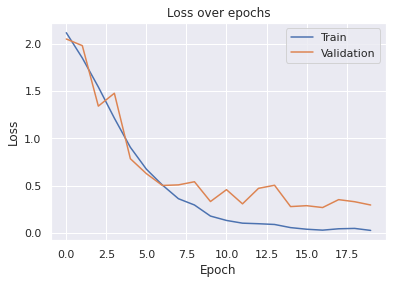

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
preds = model.predict_generator(validation_generator)
validation_df = pd.DataFrame(columns=["prediction", "groundtruth", "correct_prediction"])

for pred, groundtruth in zip(preds[:16], validation_generator.__getitem__(0)[1]):
    validation_df = validation_df.append({"prediction":classes_to_predict[np.argmax(pred)],
                                       "groundtruth":classes_to_predict[np.argmax(groundtruth)],
                                       "correct_prediction":np.argmax(pred)==np.argmax(groundtruth)}, ignore_index=True)
validation_df

,prediction,groundtruth,correct_prediction
0,nocall,nocall,True
1,nocall,nocall,True
2,nocall,nocall,True
3,comter,comter,True
4,nocall,nocall,True
5,nocall,nocall,True
6,nocall,nocall,True
7,amerob,amerob,True
8,amerob,amerob,True
9,nocall,nocall,True


In [ ]:
!rm -rf /kaggle/working/melspectrogram_dataset

# New section

In [ ]:
model.load_weights("best_model.h5")

In [ ]:
def predict_on_melspectrogram(song_sample, sample_length):
    N_mels=216

    if len(song_sample)>=sample_length:
        mel = melspectrogram(song_sample, n_mels=N_mels)
        db = librosa.power_to_db(mel)
        normalised_db = sklearn.preprocessing.minmax_scale(db)
        db_array = (np.asarray(normalised_db)*255).astype(np.uint8)

        prediction = model.predict(np.array([np.array([db_array, db_array, db_array]).T]))
        predicted_bird = classes_to_predict[np.argmax(prediction)]
        return predicted_bird
    else:
        return "nocall"

In [ ]:
def predict_submission(df, audio_file_path):

    loaded_audio_sample = []
    previous_filename = ""
    wave_data = []
    wave_rate = None
    sample_length = None

    for idx,row in df.iterrows():
        #I added this exception as I've heard that some files may be corrupted.
        try:
            if previous_filename == "" or previous_filename!=row.audio_id:
                filename = '{}/{}.mp3'.format(audio_file_path, row.audio_id)
                wave_data, wave_rate = librosa.load(filename)
                sample_length = 5*wave_rate
            previous_filename = row.audio_id

            #basically allows to check if we are running the examples or the test set.
            if "site" in df.columns:
                if row.site=="site_1" or row.site=="site_2":
                    song_sample = np.array(wave_data[int(row.seconds-5)*wave_rate:int(row.seconds)*wave_rate])
                elif row.site=="site_3":
                    #for now, I only take the first 5s of the samples from site_3 as they are groundtruthed at file level
                    song_sample = np.array(wave_data[0:sample_length])
            else:
                #same as the first condition but I isolated it for later and it is for the example file
                song_sample = np.array(wave_data[int(row.seconds-5)*wave_rate:int(row.seconds)*wave_rate])

            predicted_bird = predict_on_melspectrogram(song_sample, sample_length)
            df.at[idx,"birds"] = predicted_bird
        except:
            df.at[idx,"birds"] = "nocall"
    return df

In [ ]:
audio_file_path = "/content/drive/MyDrive/kaggle/bird_det/example_test_audio"
example_df = pd.read_csv("/content/drive/MyDrive/kaggle/bird_det/example_test_audio_summary.csv")
#Ajusting the example filenames and creating the audio_id column to match with the test file.
example_df["audio_id"] = [ "BLKFR-10-CPL_20190611_093000.pt540" if filename=="BLKFR-10-CPL" else "ORANGE-7-CAP_20190606_093000.pt623" for filename in example_df["filename"]]

if os.path.exists(audio_file_path):
    example_df = predict_submission(example_df, audio_file_path)
example_df

,filename_seconds,birds,filename,seconds,audio_id
0,BLKFR-10-CPL_20190611_093000_5,wesmea,BLKFR-10-CPL,5,BLKFR-10-CPL_20190611_093000.pt540
1,BLKFR-10-CPL_20190611_093000_10,wesmea,BLKFR-10-CPL,10,BLKFR-10-CPL_20190611_093000.pt540
2,BLKFR-10-CPL_20190611_093000_15,wesmea,BLKFR-10-CPL,15,BLKFR-10-CPL_20190611_093000.pt540
3,BLKFR-10-CPL_20190611_093000_20,wesmea,BLKFR-10-CPL,20,BLKFR-10-CPL_20190611_093000.pt540
4,BLKFR-10-CPL_20190611_093000_25,wesmea,BLKFR-10-CPL,25,BLKFR-10-CPL_20190611_093000.pt540
...,...,...,...,...,...
148,ORANGE-7-CAP_20190606_093000_280,wesmea,ORANGE-7-CAP,280,ORANGE-7-CAP_20190606_093000.pt623
149,ORANGE-7-CAP_20190606_093000_285,wesmea,ORANGE-7-CAP,285,ORANGE-7-CAP_20190606_093000.pt623
150,ORANGE-7-CAP_20190606_093000_290,wesmea,ORANGE-7-CAP,290,ORANGE-7-CAP_20190606_093000.pt623
151,ORANGE-7-CAP_20190606_093000_295,wesmea,ORANGE-7-CAP,295,ORANGE-7-CAP_20190606_093000.pt623


In [ ]:
test_file_path = "/kaggle/input/birdsong-recognition/test_audio"
test_df = pd.read_csv("/kaggle/input/birdsong-recognition/test.csv")
submission_df = pd.read_csv("/kaggle/input/birdsong-recognition/sample_submission.csv")

if os.path.exists(test_file_path):
    submission_df = predict_submission(test_df, test_file_path)

submission_df[["row_id","birds"]].to_csv('submission.csv', index=False)
submission_df.head()

,row_id,birds
0,site_1_0a997dff022e3ad9744d4e7bbf923288_5,nocall
1,site_1_0a997dff022e3ad9744d4e7bbf923288_10,nocall
2,site_1_0a997dff022e3ad9744d4e7bbf923288_15,nocall
